In [1]:
%load_ext autoreload
%autoreload 2

In [6]:

import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from skimage.transform import resize


In [3]:
from preprocessing.smoothing import clean_using_pca

In [4]:

data_folder='E://HeadRestrainedDataset//all_csv//'
protocol_name='all_csv'
path='E://HeadRestrainedDataset//all_csv//'

filelist=[]
for file in os.listdir(path):
    if file.endswith(".csv"):
        filelist.append(os.path.join(path, file))


In [26]:
filelist = ['2021-10-07-nefma-7dpf-f1-all_logs']

Tensor = np.zeros((3500,10,0))
stop = False
df = pd.read_csv('E://HeadRestrainedDataset//all_csv//'+filelist[0]+'.csv')
#df = pd.read_csv(filelist[0])

NumSegment = 16

relative_tail_angle = df[['angle'+str(i) for i in range(NumSegment)]]
relative_tail_angle = relative_tail_angle.values
T = np.max(relative_tail_angle.shape)

cumul_tail_angle=np.cumsum(relative_tail_angle,1)

tail_angle = resize(cumul_tail_angle, (cumul_tail_angle.shape[0], 10),order=0) # 0 for nearest neighbor
tail_angle[tail_angle<-10]=np.nan

T = tail_angle.shape[0]

In [36]:
# DMD for Cleanup??

# Create Pipeline

In [40]:
from preprocessing.smoothing import create_preprocess
from sparse_coding.sparse_coding import create_sparse_coder
from segmentation.segment import create_segmentation_from_code
from classification.classify import create_classifier
from classification.template_bouts import generate_template_bouts

In [41]:
def create_pipeline(preprocess,sparse_coder,segment_from_code,classifier):

    def pipeline(tail_angle):

        tail_angle_clean = preprocess(tail_angle)
        z,tail_angle_hat = sparse_coder(tail_angle_clean)
        onset,offset,bouts_array = segment_from_code(z,tail_angle)
        bout_cat = classifier(bouts_array)

        return tail_angle_clean,z,tail_angle_hat,onset,offset,bouts_array,bout_cat

    return pipeline

In [42]:

templates_flat,templates_labels,NameCat,Duration_after_Downsampling = generate_template_bouts(format='tail',template_duration = 140,target_fps=700,ExludeCaptureSwim=True,delays=np.arange(10,120,3))
Dict = np.load('./sparse_coding/3atomsDictTu.npy')


In [43]:
preprocess = create_preprocess(limit_na=5,num_pcs=3)
sparse_coder = create_sparse_coder(Dict,lmbda=0.01,gamma=0.05,mu=0.05,Whn=60)
segment_from_code = create_segmentation_from_code(Min_Code_Ampl=1,SpikeDist=120,Bout_Duration=140)
classifier = create_classifier(templates_flat,templates_labels,n_neighbors=5)
pipeline = create_pipeline(preprocess,sparse_coder,segment_from_code,classifier)

In [44]:
#  Runing full pipeline
tail_angle_clean,z,tail_angle_hat,onset,offset,bouts_array,bout_cat = pipeline(tail_angle)

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  5.87e+03  4.87e+03  2.15e+04  8.75e+03  6.87e+03  4.17e-01  1.21e+01  1.50e+00
   1  7.44e+03  4.10e+03  3.29e+04  3.49e+04  2.54e+04  3.53e-01  2.05e+00  1.50e+00
   2  9.00e+03  4.20e+03  3.23e+04  5.20e+04  3.74e+04  5.38e-01  3.64e-01  6.06e-01
   3  8.96e+03  5.03e+03  2.28e+04  4.23e+04  3.16e+04  5.52e-01  2.42e-01  7.17e-01
   4  8.68e+03  5.20e+03  1.85e+04  3.71e+04  2.88e+04  3.92e-01  1.99e-01  1.06e+00
   5  8.39e+03  5.16e+03  1.62e+04  3.15e+04  3.00e+04  1.86e-01  2.49e-01  1.44e+00
   6  8.74e+03  5.04e+03  1.75e+04  3.43e+04  3.63e+04  1.63e-01  1.50e-01  1.21e+00
   7  8.58e+03  5.09e+03  1.60e+04  3.06e+04  3.61e+04  1.43e-01  1.34e-01  1.21e+00
   8  8.47e+03  5.16e+03  1.48e+04  2.81e+04  3.51e+04  1.28e-01  9.23e-02  1.21e+00
   9  8.39e+03  5.20e+03  1.41e+04  2.58e+04  3.52e+04  8.65e-02 

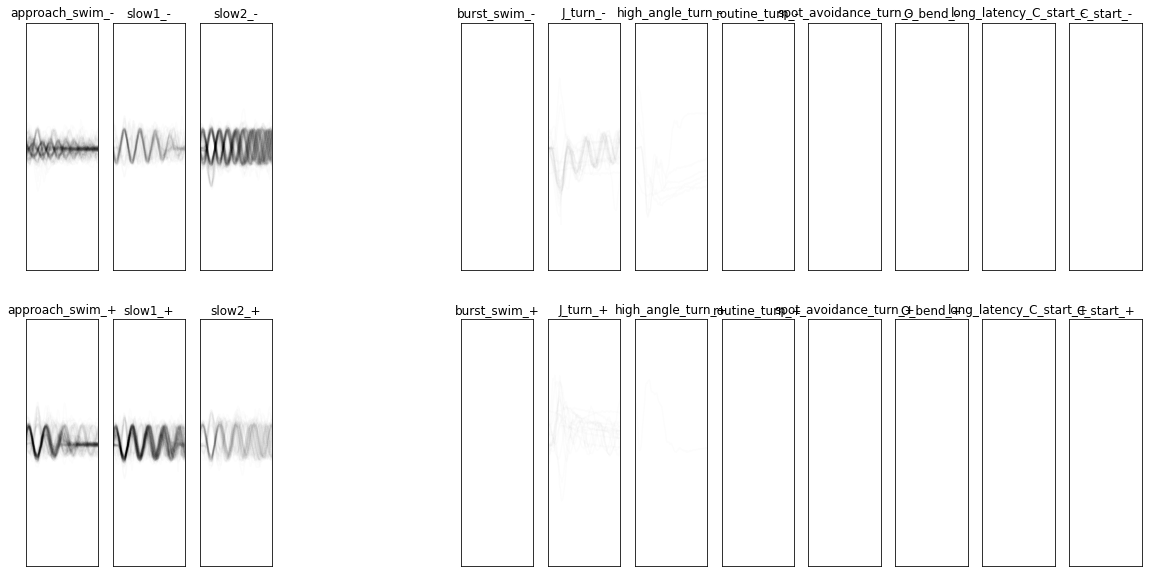

In [45]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    
    id = np.where(bout_cat==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(bouts_array[id,:,-1].T,'k',alpha=0.01)

    ax0.set_xlim(0,120)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


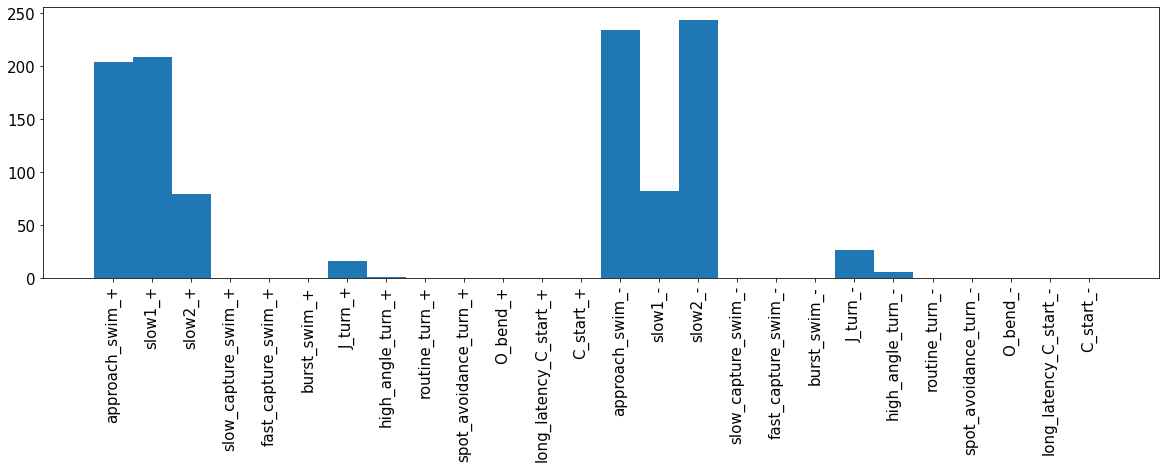

In [59]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,5)) 

plt.hist(bout_cat,np.linspace(-0.5,25.5,27))
plt.xticks(np.arange(26),NameCat, rotation='vertical')
plt.show()

# Make Figure 2

In [46]:
from scipy.signal import find_peaks
z_normalized = np.copy(z)
#for i in range(z.shape[1]):
#    z_normalized[:,i] = z[:,i]/np.std(z[:,i])

z_max = np.max(np.abs(z_normalized),axis=1)
peaks, _ = find_peaks(z_max, height=1,distance=120)
peaks_bin = np.zeros(T)
peaks_bin[peaks]=1

## For each peak find next peak or gap in peaks...
Bout_Duration = 120
kernel = np.ones(Bout_Duration)
filtered_forward = np.convolve(kernel,peaks_bin, mode='full')[:peaks_bin.shape[0]]
is_tail_active = 1.0*(filtered_forward>0)#*(filtered_backward>0)

In [53]:

Duration = 700*7
IdSt = np.random.randint(z.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/700,Duration)
sub_onset,sub_offset,sub_i= [],[],[]

for i,(on_,off_) in enumerate(zip(onset,offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)

sub_peaks = np.where(peaks_bin[IdSt:IdEd]==1)[0]
sub_i = np.array(sub_i)
print(len(sub_peaks))

13


In [54]:
templates_flat,templates_labels,NameCat,Duration_after_Downsampling = generate_template_bouts(format='tail',template_duration = 140,target_fps=700,ExludeCaptureSwim=True,delays=np.arange(-10,10,1))


In [55]:
## For each bous in interval find nearest neighbor

from sklearn.neighbors import KNeighborsClassifier

print(bouts_array.shape,len(onset))

sub_bouts_array = bouts_array[sub_i]
print(sub_bouts_array.shape)


# FLATTEN ARRAY:
sub_bouts_array = sub_bouts_array[:,:,:]
sub_bouts_array_flat = np.reshape(np.swapaxes(sub_bouts_array, 1, 2),(sub_bouts_array.shape[0],sub_bouts_array.shape[1]*sub_bouts_array.shape[2]))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(templates_flat, templates_labels)
res = knn.kneighbors(sub_bouts_array_flat)
Nearest_bouts = templates_flat[res[1][:,0],140*6:]


(1103, 140, 7) 1103
(13, 140, 7)


In [56]:
from matplotlib.patches import Rectangle

(0.0, 7.0)

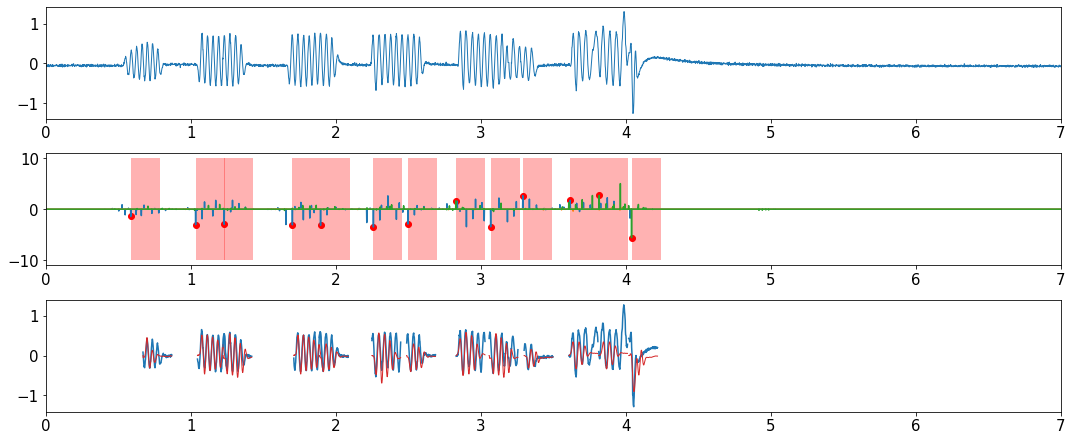

In [57]:

fig, ax = plt.subplots(facecolor='white',figsize=(15,10),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(5,1)

ax = plt.subplot(G[0])
#ax.plot(t,tail_angle[IdSt:IdEd,7],'k',lw=1)
ax.plot(t,tail_angle_clean[IdSt:IdEd,7],lw=1)
ax.set_xlim(0,Duration/700)

ax = plt.subplot(G[1])
ax.plot(t,z[IdSt:IdEd,:])
y =-(1-2*(np.max((z[IdSt:IdEd]),axis=1)>np.max(-(z[IdSt:IdEd]),axis=1)))*np.max(np.abs(z[IdSt:IdEd]),axis=1)*peaks_bin[IdSt:IdEd]
ax.scatter(t[sub_peaks],y[sub_peaks],color = 'r')
for p in sub_peaks:
    ax.add_patch(Rectangle((t[p],-10),140/700,20,facecolor="red",alpha=0.3))
#ax.vlines(t[sub_peaks],-10,10)
ax.set_xlim(0,Duration/700)

ax = plt.subplot(G[2])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/700,tail_angle_clean[on_:off_,6],'tab:blue')
    off_ = on_+140
    ax.plot((np.arange(on_,off_)-IdSt)/700,Nearest_bouts[i,:],'tab:red',lw=1)
 
ax.set_xlim(0,Duration/700)